In [1]:
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
LN_RECEPTION_POWER_PATH = os.path.join(os.getcwd(), 'data', 'modified1', 'LogNormal', 'receptionPower.csv')
LN_PACKET_ERROR_RATE_PATH = os.path.join(os.getcwd(), 'data', 'modified1', 'LogNormal', 'packetErrorRate.csv')
LN_RCVD_PK_SEQ_NO_PATH = os.path.join(os.getcwd(), 'data', 'modified1', 'LogNormal', 'rcvdPkSeqNo.csv')

R_RECEPTION_POWER_PATH = os.path.join(os.getcwd(), 'data', 'modified1', 'Rician', 'receptionPower.csv')
R_PACKET_ERROR_RATE_PATH = os.path.join(os.getcwd(), 'data', 'modified1', 'Rician', 'packetErrorRate.csv')
R_RCVD_PK_SEQ_NO_PATH = os.path.join(os.getcwd(), 'data', 'modified1', 'Rician', 'rcvdPkSeqNo.csv')

In [3]:
D = 100  # длина сообщения [байт]
L = D + 59  # общая длина пакета [байт]
T = 0.2  # средний период передачи пакетов [с] (200 мс)
P_t = 0.04  # мощность передатчика [Вт] (40 мВт)
F = 250_000_000  # частота несущей радиоканала [Гц] (250 МГц)
R = 10_000  # скорость передачи данных радиоканала [бит/с] (10 кбит/с)
W = 20_000  # ширина полосы приёмника [Гц] (20 кГц)
P_n = -110  # фоновый уровень шума [дБм]
V = 2  # скорость перемещения приёмника [м/с]
C = 299_792_458  # скорость света [м/с]

In [4]:
def wavelength(light_speed, frequency):
    return light_speed / frequency    

def distance(time):
    return time * V + 5

def Vt_to_dBm(Vt):
    return 10 * math.log10(Vt * 1000)

def times_to_dB(times):
    return 10 * math.log10(times)

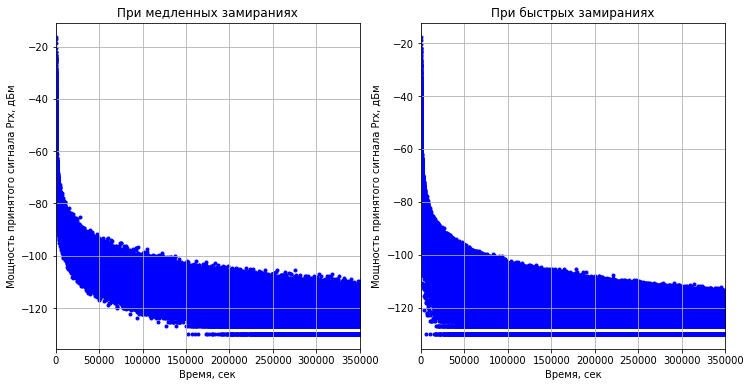

In [5]:
TIME = 350000

# полученные LogNormal
ln_reception_power_df = pd.read_csv(LN_RECEPTION_POWER_PATH, header=None)
ln_times = []
ln_reception_powers = []
for time, power in zip(ln_reception_power_df[0].tolist(), ln_reception_power_df[1].tolist()):
    if power:
        ln_times.append(time)
        ln_reception_powers.append(Vt_to_dBm(power))
# полученные Rician
r_reception_power_df = pd.read_csv(R_RECEPTION_POWER_PATH, header=None)
r_times = []
r_reception_powers = []
for time, power in zip(r_reception_power_df[0].tolist(), r_reception_power_df[1].tolist()):
    if power:
        r_times.append(time)
        r_reception_powers.append(Vt_to_dBm(power))


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('При медленных замираниях')
axes[0].scatter(ln_times, ln_reception_powers, marker='.', color='blue')
axes[0].grid(True)
axes[0].set_xlim(0, TIME)
axes[0].set_xlabel('Время, сек')
axes[0].set_ylabel('Мощность принятого сигнала Prx, дБм')

axes[1].set_title('При быстрых замираниях')
axes[1].scatter(r_times, r_reception_powers, marker='.', color='blue')
axes[1].grid(True)
axes[1].set_xlim(0, TIME)
axes[1].set_xlabel('Время, сек')
axes[1].set_ylabel('Мощность принятого сигнала Prx, дБм')

plt.show()

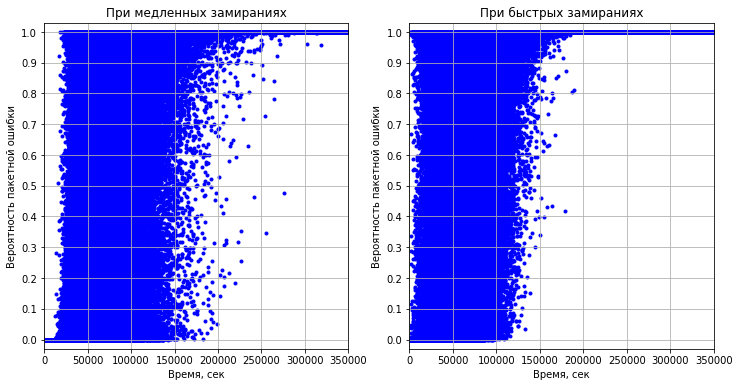

In [6]:
# полученные LogNormal
ln_bit_error_rate_df = pd.read_csv(LN_PACKET_ERROR_RATE_PATH, header=None)
ln_times = ln_bit_error_rate_df[0]
ln_bit_error_rates = ln_bit_error_rate_df[1]
# полученные Rician
r_packet_error_rate_df = pd.read_csv(R_PACKET_ERROR_RATE_PATH, header=None)
r_times = r_packet_error_rate_df[0]
r_packet_error_rates = r_packet_error_rate_df[1]


y_ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('При медленных замираниях')
axes[0].scatter(ln_times, ln_bit_error_rates, marker='.', color='blue')
axes[0].grid(True)
axes[0].set_xlim(0, TIME)
axes[0].set_ylim(-0.03, 1.03)
axes[0].set_yticks(y_ticks)
axes[0].set_xlabel('Время, сек')
axes[0].set_ylabel('Вероятность пакетной ошибки')

axes[1].set_title('При быстрых замираниях')
axes[1].scatter(r_times, r_packet_error_rates, marker='.', color='blue')
axes[1].grid(True)
axes[1].set_xlim(0, TIME)
axes[1].set_ylim(-0.03, 1.03)
axes[1].set_yticks(y_ticks)
axes[1].set_xlabel('Время, сек')
axes[1].set_ylabel('Вероятность пакетной ошибки')

plt.show()

In [7]:
def num_lost_packets(times, packet_ids):
    """Считает, сколько пакетов было потеряно.
    
    Args:
        times: список с временами прибытия пакетов.
        packer_ids: список с id пакетов.
        
    Returns:
        new_times: список с пременами, когда обнаруживается потеря пакетов.
        numbers_of_lost_packets: количество потерянных пакетов.
    """
    new_times = []
    numbers_of_lost_packets = []
    for i in range(1, len(packet_ids) - 2):
        number_of_lost_packets = packet_ids[i] - packet_ids[i - 1]
        if number_of_lost_packets != 1:
            new_times.append(times[i])
            numbers_of_lost_packets.append(number_of_lost_packets)
    return new_times, numbers_of_lost_packets

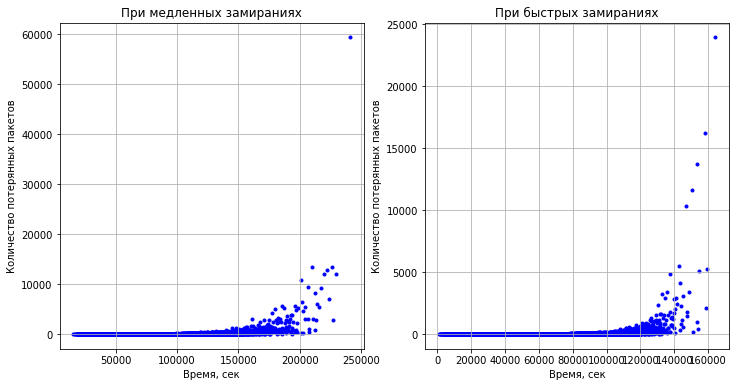

In [8]:
# полученные LogNormal
ln_recived_packet_seq_no_df = pd.read_csv(LN_RCVD_PK_SEQ_NO_PATH, header=None)
ln_times = ln_recived_packet_seq_no_df[0]
ln_packet_ids = ln_recived_packet_seq_no_df[1]
ln_new_times, ln_numbers_of_lost_packets = num_lost_packets(ln_times, ln_packet_ids)
# полученные Rician
r_recived_packet_seq_no_df = pd.read_csv(R_RCVD_PK_SEQ_NO_PATH, header=None)
r_times = r_recived_packet_seq_no_df[0]
r_packet_ids = r_recived_packet_seq_no_df[1]
r_new_times, r_numbers_of_lost_packets = num_lost_packets(r_times, r_packet_ids)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('При медленных замираниях')
axes[0].scatter(ln_new_times, ln_numbers_of_lost_packets, marker='.', color='blue')
axes[0].grid(True)
axes[0].set_xlabel('Время, сек')
axes[0].set_ylabel('Количество потерянных пакетов')

axes[1].set_title('При быстрых замираниях')
axes[1].scatter(r_new_times, r_numbers_of_lost_packets, marker='.', color='blue')
axes[1].grid(True)
axes[1].set_xlabel('Время, сек')
axes[1].set_ylabel('Количество потерянных пакетов')

plt.show()